In [1]:
from numpy import *
from PlotFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy import random
from tqdm import tqdm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.special import erf
from scipy.optimize import fsolve

def ConversionFactors(costh_samples,nbins=500):
    h,ce = histogram(costh_samples,nbins)
    cc = (ce[1:]+ce[0:-1])/2
    
    P_costh = h/sum(h) 
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf(-P0*cc/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3)
    cval_excl = 1.64/res
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf((5-P0*cc)/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3+5)
    cval_disc = (5+1.64)/res
    return cval_excl,cval_disc



In [2]:
# Random DP polarisations sampled isotropically
ngen = 100000
costh = 2*random.uniform(size=ngen)-1
th = arccos(costh)
cos2th = cos(2*th)

# Analytic results (see mathematica notebook for derivation)
costh_av_Z = lambda lat : (1/8)*(3+cos(2*th)-(1+3*cos(2*th))*cos(2*lat*pi/180))
costh_av_N = lambda lat : (1/8)*(3+cos(2*lat*pi/180)+(1+3*cos(2*lat*pi/180))*cos(2*th))
costh_av_W = lambda lat : (sin(th)**2)/2
costh_av_ZW = lambda lat : (1/8)*(5-cos(2*lat*pi/180)-(1+3*cos(2*lat*pi/180))*cos(2*th)) # North-facing
costh_av_ZN = lambda lat : (1/4)*(3+cos(2*th)) # West-facing
costh_av_NW = lambda lat : (1/8)*(5+cos(2*lat*pi/180)+(-1+3*cos(2*lat*pi/180))*cos(2*th)) # Zenith-facing

# Loop over latitudes to show the dependence on lat
nloc = 500
lats = linspace(-75,85,nloc)
lons = linspace(-180,180,2*nloc)
val_N = zeros(shape=nloc)
val_Z = zeros(shape=nloc)
val_ZW = zeros(shape=nloc)
val_NW = zeros(shape=nloc)

val_disc_N = zeros(shape=nloc)
val_disc_Z = zeros(shape=nloc)
val_disc_ZW = zeros(shape=nloc)
val_disc_NW = zeros(shape=nloc)

# For each latitude calculate 5th percentile 
# i.e. the value above which 95% of the distribution lies
for i in tqdm(range(0,nloc)):    
    val_Z[i],val_disc_Z[i] = ConversionFactors(costh_av_Z(lats[i]))
    val_N[i],val_disc_N[i] = ConversionFactors(costh_av_N(lats[i]))
    val_ZW[i],val_disc_ZW[i] = ConversionFactors(costh_av_ZW(lats[i]))
    val_NW[i],val_disc_NW[i] = ConversionFactors(costh_av_NW(lats[i]))

pos1 = array([[47.6062,-122.3321], # ADMX
              [41.3163,-72.9223], # HAYSTAC
             [36.3504, 127.3845], # CAPP
             [45.3457, 11.9639], # QUAX
             [29.6516, -82.3248], # UF
             [46.2044, 6.1432], # RADES
             [40.7793, -72.9154], # RBF
             [-31.9523, 115.8613], # ORGAN
             [42.3736, -71.1097]]) # ABRACADABRA

pos2 = array([[41.8085, 12.6761],
              [53.5724, 9.8805]])

pos3 = array([[41.8364, -88.2636],
              [48.7367, 2.1800],
              [35.6762, 139.6503],
              [49.0069, 8.4037],
              [38.544,-121.74]])

pos4 = array([[24.4539, 54.3773],
              [37.4275-1, -122.1697]])


100%|██████████| 500/500 [00:06<00:00, 76.48it/s]


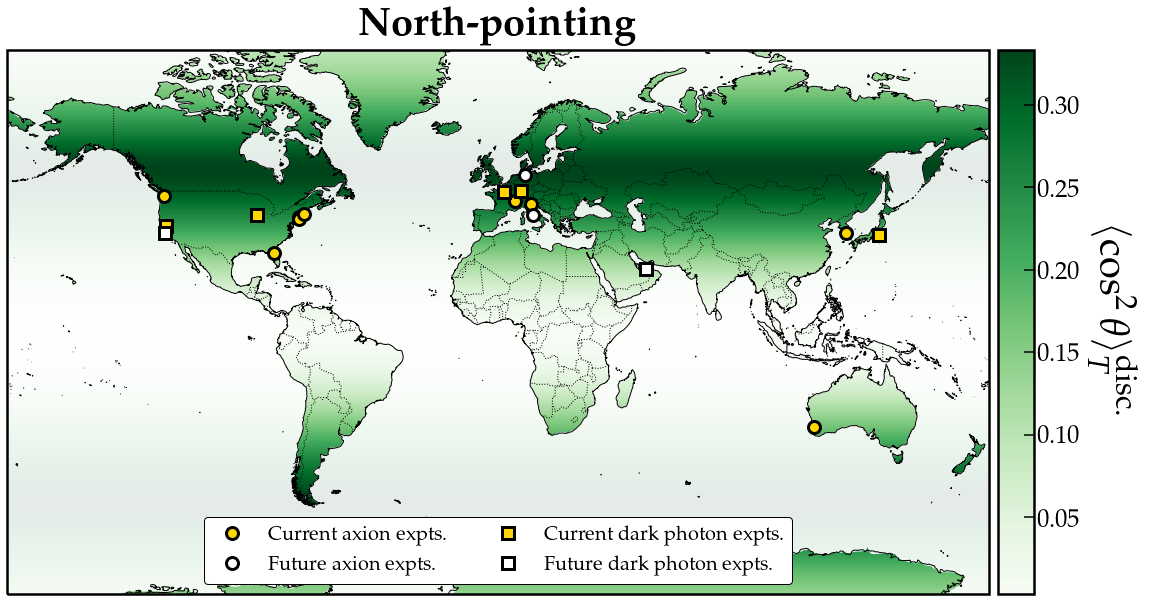

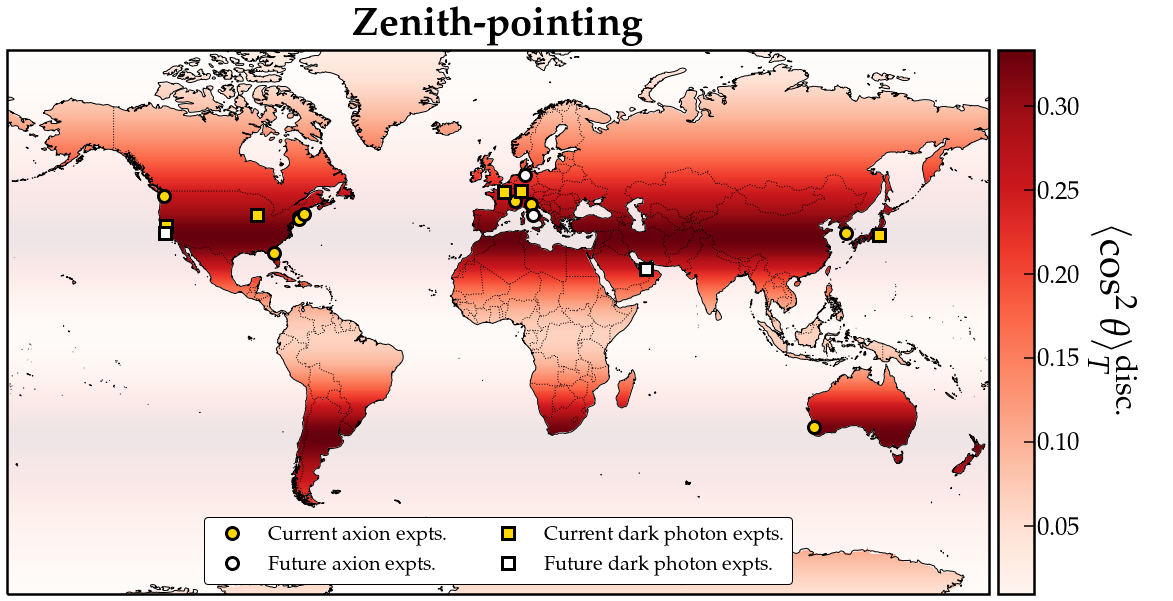

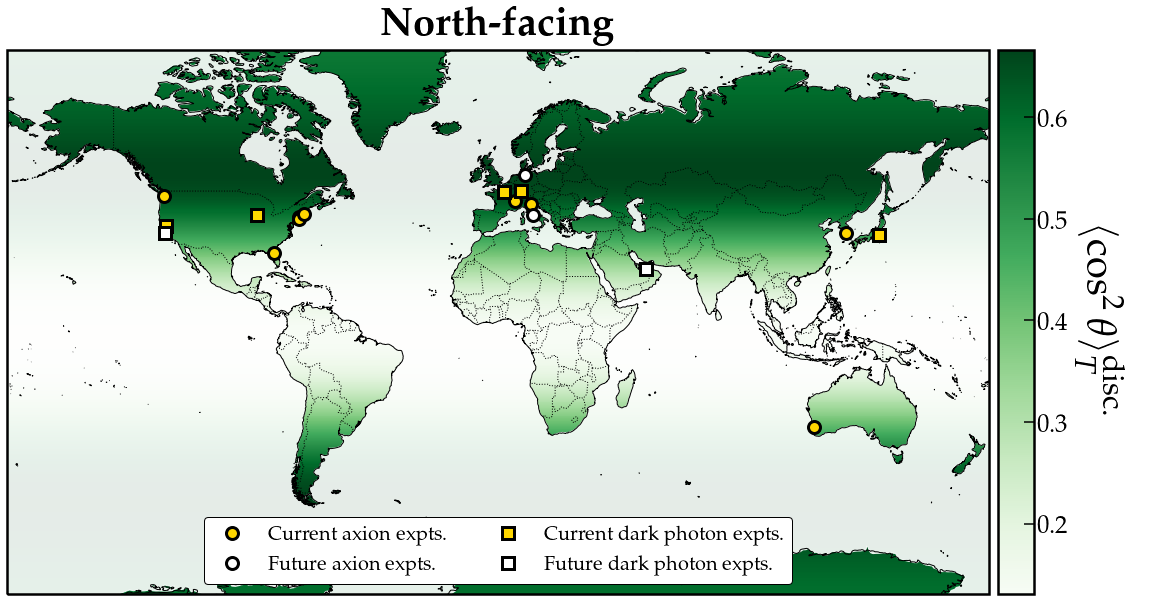

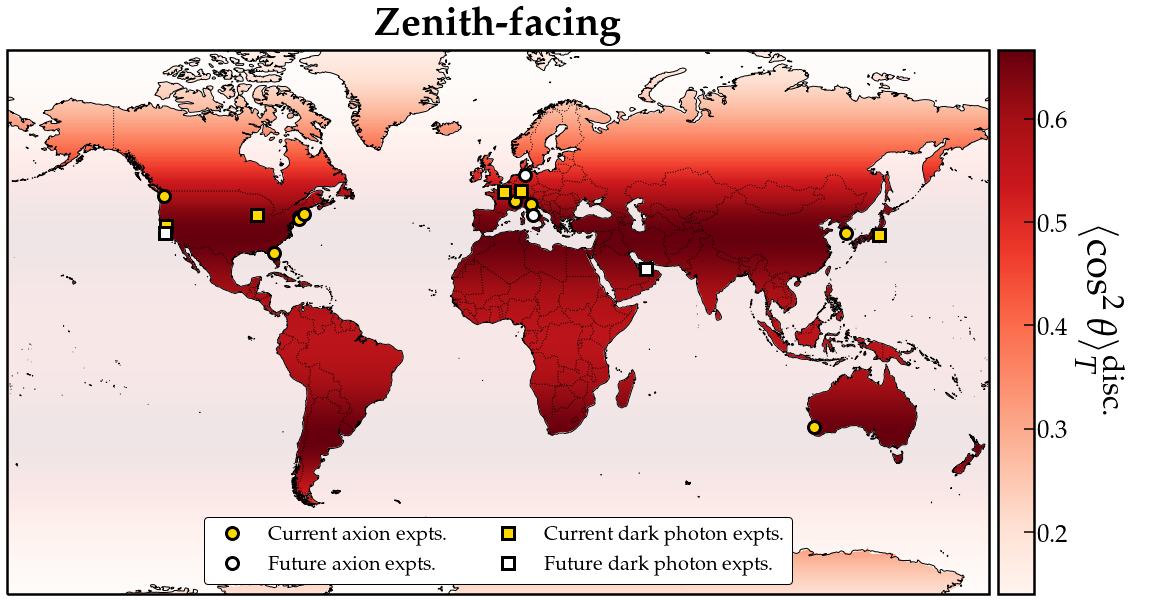

In [4]:
def LocationMap(val,lats,lons,cmap,tit):
    fig,ax = MySquarePlot(size_x=25,size_y=10)
    ax = plt.axes(projection=ccrs.Miller(),extent=(-180,180,-75,80))

    im = ax.pcolormesh(lons,lats,tile(val.T,(2*nloc,1)).T,cmap=cmap,alpha=1,transform=ccrs.PlateCarree(),rasterized = True)
    im.set_edgecolor('face')

    ax.add_feature(cartopy.feature.OCEAN,color='w',zorder=2,alpha=0.9)
   
    ax.plot(pos1[:,1],pos1[:,0],'o',ms=12,mfc='gold',mec='k',mew=3,label='Current axion expts.',transform=ccrs.PlateCarree(),zorder=12)
    ax.plot(pos2[:,1],pos2[:,0],'o',ms=12,mfc='w',mec='k',mew=3,label='Future axion expts.',transform=ccrs.PlateCarree(),zorder=12)
    ax.plot(pos3[:,1],pos3[:,0],'s',ms=12,mfc='gold',mec='k',mew=3,label='Current dark photon expts.',transform=ccrs.PlateCarree(),zorder=12)
    ax.plot(pos4[:,1],pos4[:,0],'s',ms=12,mfc='w',mec='k',mew=3,label='Future dark photon expts.',transform=ccrs.PlateCarree(),zorder=12)
    
    ax.coastlines(lw=1,color='k',zorder=3,resolution='50m')
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':',zorder=3)
    ax.outline_patch.set_linewidth(2.5)

    plt.title(tit,fontsize=40,pad=15)

    cbaxes = fig.add_axes([0.79, 0.125, 0.02, 0.755]) 
    cbar = plt.colorbar(im,cax = cbaxes)
    cbar.set_label(r'$\langle \cos^2{\theta}\rangle_T^{\rm disc.}$', rotation=-90,labelpad=45,fontsize=40)

    cbar.ax.tick_params(which='major',length=10,width=1.5,direction='in')
    cbar.solids.set_rasterized(True)
    cbar.solids.set_edgecolor("face")

    plt.gcf().text(0.87,0.5,'---',color='w',zorder=-100)

    ax.legend(loc='lower center',framealpha=1,fontsize=20,ncol=2,edgecolor='k',fancybox=True)
    return fig,ax

fig,ax = LocationMap(val_disc_N,lats,lons,cm.Greens,r'{\bf North-pointing}')
MySaveFig(fig,'Map_North')

fig,ax = LocationMap(val_disc_Z,lats,lons,cm.Reds,r'{\bf Zenith-pointing}')
MySaveFig(fig,'Map_Zenith')

fig,ax = LocationMap(val_disc_ZW,lats,lons,cm.Greens,r'{\bf North-facing}')
MySaveFig(fig,'Map_NorthFacing')

fig,ax = LocationMap(val_disc_NW,lats,lons,cm.Reds,r'{\bf Zenith-facing}')
MySaveFig(fig,'Map_ZenithFacing')